# GradCAM
## Inteligencia Artificial
### Alan García Zermeño
21/04/2023

### Usamos un subset de la base de datos de neumonía. Se comparte la carpeta donde se guardó dicha sub-base de datos y el modelo realizado:
https://drive.google.com/drive/folders/1t9E3hMX5qqx8wgpskAknSN6p73ixTa2c?usp=sharing

Se implementó un nuevo modelo especial para esta tarea, ya que el modelo realizdo para la tarea anterior fue bastante más malo para clasificar.

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics,models,layers,optimizers,callbacks
import sklearn.metrics as skmetrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
train = '/content/drive/MyDrive/Colab Notebooks/split_pneumonia/train'
val = '/content/drive/MyDrive/Colab Notebooks/split_pneumonia/val'
test = '/content/drive/MyDrive/Colab Notebooks/split_pneumonia/test'

Vdatag = ImageDataGenerator(rescale=1/255)
Tedatag  = ImageDataGenerator(rescale=1/255)
Trdatag = ImageDataGenerator(rotation_range = 21,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    rescale = 1/255,)

In [ ]:
s_ima,bs = (224,224),8
train_data = Trdatag.flow_from_directory(train, target_size=s_ima, batch_size=bs, class_mode='binary')
val_data = Vdatag.flow_from_directory(val, target_size=s_ima, batch_size=bs, class_mode='binary')
test_data = Tedatag.flow_from_directory(test, target_size=s_ima, batch_size=bs, class_mode='binary')
test_lab = test_data.classes

Found 1778 images belonging to 2 classes.
Found 187 images belonging to 2 classes.
Found 897 images belonging to 2 classes.


In [ ]:
img_size = (224,224,3)

model = VGG16(input_shape = img_size,
                     include_top = True,
                     weights     = 'imagenet')
preprocess_input   = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name   = "block5_conv3"
#classifier_layer_names = ["block5_pool","global_max_pooling2d_1","dense_2","dropout_1","dense_3","dense_4"]#['block5_pool', 'flatten', 'fc1', 'fc2',"predictions",]

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers:
  print(layer.name)
  layer.trainable = False

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


In [ ]:
last_layer = model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [ ]:
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(model.input, x)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg_classifier = model.fit(train_data,
steps_per_epoch=(50),
epochs = 5,
validation_data=val_data,
validation_steps=(50),
batch_size = 8,
verbose = 1)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 1.0013 - acc: 0.5685

50/50 [==============================] - 246s 5s/step - loss: 1.0013 - acc: 0.5685 - val_loss: 0.9993 - val_acc: 0.5401
Epoch 2/5
50/50 [==============================] - 164s 3s/step - loss: 1.0019 - acc: 0.5025
Epoch 3/5
50/50 [==============================] - 163s 3s/step - loss: 0.9285 - acc: 0.5675
Epoch 4/5
50/50 [==============================] - 163s 3s/step - loss: 0.9342 - acc: 0.5125
Epoch 5/5
50/50 [==============================] - 160s 3s/step - loss: 0.8618 - acc: 0.5964


## Basado en nuestro modelo de transferencia de conocimiento con imágenes de neumonía, aplicamos la función GradCAM utilizando las últimas capas del modelo.

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/split_pneumonia/model2/model.h5')
#model.load_weights("/content/drive/MyDrive/Colab Notebooks/split_pneumonia/model2/model.h5")

In [ ]:
classifier_layer_names = ["block5_pool","global_max_pooling2d_1","dense_3","dropout","dense_4","dense_5"]

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        #print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

## Se muestran un par de imágenes con neumonía para probar la función y ploteamos el resultado del gradcam y de la saliencia.

In [ ]:
img = np.asarray(test_data[1][0][2])
img = np.array([img])

grad_cam, saliency = make_gradcam_heatmap(img, 
                                          model, 
                                          last_conv_layer_name, 
                                          classifier_layer_names)

(-0.5, 223.5, 223.5, -0.5)

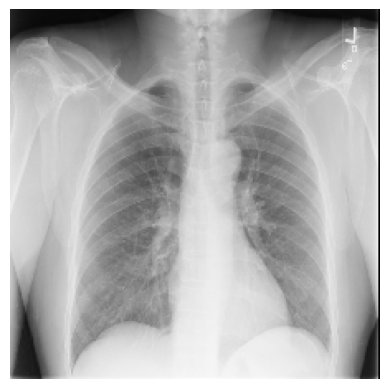

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img[0])
plt.axis("off")

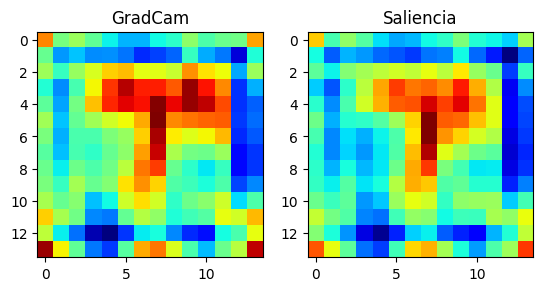

In [ ]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

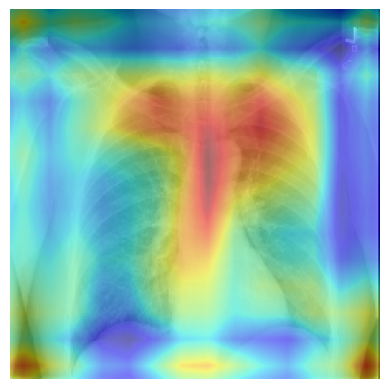

In [ ]:
resized_heatmap=resize(saliency, (224,224))
    
fig, ax = plt.subplots()
ax.imshow(img[0])
ax.imshow(resized_heatmap, alpha=0.5, cmap='jet')
plt.axis("off")
#plt.title(title)
plt.show()

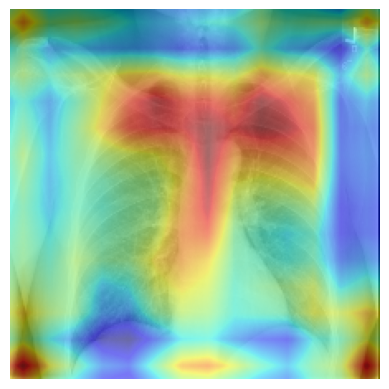

In [ ]:
resized_heatmap=resize(grad_cam, (224,224))
    
fig, ax = plt.subplots()
ax.imshow(img[0])
ax.imshow(resized_heatmap, alpha=0.5, cmap='jet')
plt.axis("off")
#plt.title(title)
plt.show()

tf.Tensor(0, shape=(), dtype=int64)
[0. 0. 1. 1. 0. 0. 1. 0.]


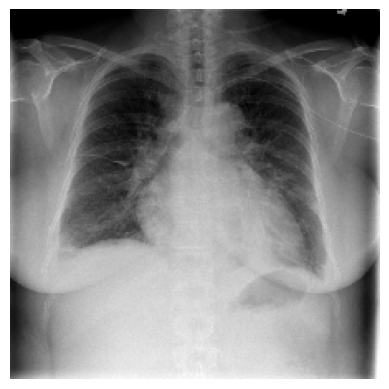

In [ ]:
img = np.asarray(test_data[3][0][3])
img = np.array([img])

#img = np.reshape(img,(256,256,3))
grad_cam, saliency = make_gradcam_heatmap(img, 
                                          model, 
                                          last_conv_layer_name, 
                                          classifier_layer_names)

fig, ax = plt.subplots()
ax.imshow(img[0])
plt.axis("off")
print(test_data[3][1])

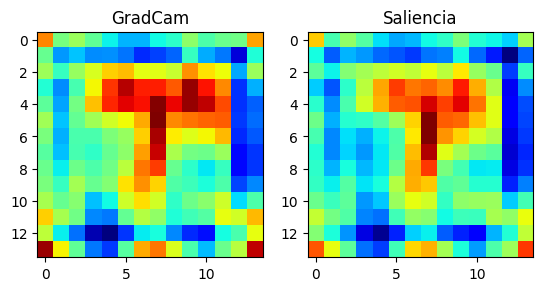

In [ ]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

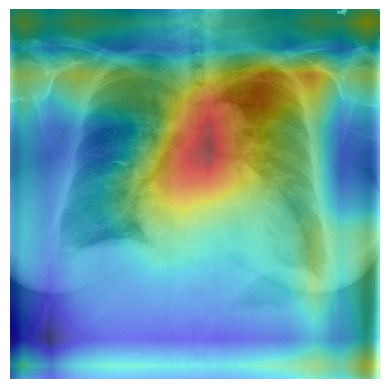

In [ ]:
resized_heatmap=resize(saliency, (224,224))
    
fig, ax = plt.subplots()
ax.imshow(img[0])
ax.imshow(resized_heatmap, alpha=0.5, cmap='jet')
plt.axis("off")
#plt.title(title)
plt.show()

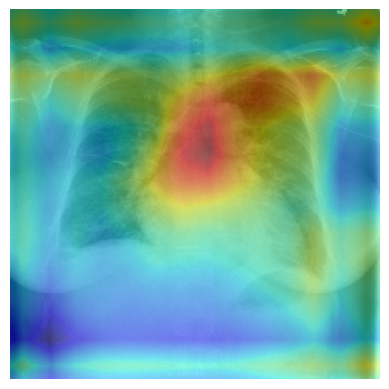

In [ ]:
resized_heatmap=resize(grad_cam, (224,224))
    
fig, ax = plt.subplots()
ax.imshow(img[0])
ax.imshow(resized_heatmap, alpha=0.5, cmap='jet')
plt.axis("off")
#plt.title(title)
plt.show()